In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving uber.csv to uber.csv
User uploaded file "uber.csv" with length 2498919 bytes


In [2]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 17.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=159b22668576e04fc807951cf1f7cf22fd3d4c7f708e2130ceef830f84e9e199
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=dd7b58c428c3967fc9f59dda7976b1f7ff598469ad43ed169a277003e47d7e37
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
#Display full data frame information
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
data1 = pd.read_csv("uber.csv")

In [14]:
data1.shape

(14215, 2)

In [15]:
data1.head()

,Datetime,Tweet
0,2016-12-30 19:57:52+00:00,"@Uber_Support my uber driver said Lebron , I'm disgusted and I will never uber again."
1,2016-12-30 19:09:21+00:00,"I ain't a snitch boi, kick rocks ya narc"
2,2016-12-30 17:40:01+00:00,My uber driver made me sit in the bed of his truck @Uber_Support
3,2016-12-30 15:50:57+00:00,Second most popular insight 2016 @Uber_Support vs @AskLyft The Battle of Ride Sharing Customer Service on @Twitter
4,2016-12-30 14:45:33+00:00,no thanks you can shove your rip off explanation where the sun don't shine


In [ ]:
x=data1['comments']

In [16]:
# Data Cleaning

# Convert to list
data = data1.Tweet.values.tolist()

data = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['my uber driver said Lebron , Im disgusted and I will never uber again.']


In [21]:
data1['cleaned_tweet']=data

In [22]:
data1.head()

,Datetime,Tweet,cleaned_tweet
0,2016-12-30 19:57:52+00:00,"@Uber_Support my uber driver said Lebron , I'm disgusted and I will never uber again.","my uber driver said Lebron , Im disgusted and I will never uber again."
1,2016-12-30 19:09:21+00:00,"I ain't a snitch boi, kick rocks ya narc","I aint a snitch boi, kick rocks ya narc"
2,2016-12-30 17:40:01+00:00,My uber driver made me sit in the bed of his truck @Uber_Support,My uber driver made me sit in the bed of his truck
3,2016-12-30 15:50:57+00:00,Second most popular insight 2016 @Uber_Support vs @AskLyft The Battle of Ride Sharing Customer Service on @Twitter,Second most popular insight 2016 vs The Battle of Ride Sharing Customer Service on
4,2016-12-30 14:45:33+00:00,no thanks you can shove your rip off explanation where the sun don't shine,no thanks you can shove your rip off explanation where the sun dont shine


In [23]:
# Tokenize
data = data1.cleaned_tweet.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['my', 'uber', 'driver', 'said', 'lebron', 'im', 'disgusted', 'and', 'will', 'never', 'uber', 'again']]


In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['my', 'uber', 'driver', 'said', 'lebron', 'im', 'disgusted', 'and', 'will', 'never', 'uber', 'again']


In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['driver', 'say', 'be', 'disgust', 'never']]


In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [32]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('be', 1), ('disgust', 1), ('driver', 1), ('never', 1), ('say', 1)]]

In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.145*"driver" + 0.060*"get" + 0.048*"go" + 0.038*"charge" + 0.038*"cancel" '
  '+ 0.034*"say" + 0.033*"use" + 0.027*"car" + 0.026*"would" + 0.025*"call"'),
 (1,
  '0.065*"help" + 0.058*"account" + 0.055*"order" + 0.047*"send" + '
  '0.041*"support" + 0.039*"thank" + 0.034*"app" + 0.030*"people" + '
  '0.027*"day" + 0.024*"contact"'),
 (2,
  '0.063*"service" + 0.056*"customer" + 0.043*"try" + 0.036*"money" + '
  '0.033*"work" + 0.028*"also" + 0.025*"food" + 0.024*"have" + 0.023*"come" + '
  '0.022*"company"'),
 (3,
  '0.083*"want" + 0.074*"refund" + 0.031*"could" + 0.028*"experience" + '
  '0.027*"share" + 0.022*"receive" + 0.020*"much" + 0.020*"reason" + '
  '0.020*"fare" + 0.018*"lose"'),
 (4,
  '0.086*"time" + 0.075*"make" + 0.057*"need" + 0.029*"pick" + 0.024*"reply" + '
  '0.019*"week" + 0.019*"last" + 0.019*"concern" + 0.018*"action" + '
  '0.017*"hope"'),
 (5,
  '0.060*"know" + 0.033*"let" + 0.027*"allow" + 0.025*"drop" + 0.025*"detail" '
  '+ 0.024*"provide" + 0.024*"en

Model Evaluation:

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.69982068322663

Coherence Score:  0.29600952164162714


In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.435790  0.033787  1       1        21.718969
1     -0.012185 -0.417291  2       1        11.542686
7     -0.037116  0.067242  3       1        10.817705
2     -0.042288  0.054060  4       1        10.552654
6     -0.046668  0.041960  5       1        9.241075 
4     -0.054054  0.049082  6       1        8.660377 
8     -0.059519  0.044512  7       1        7.135782 
5     -0.062083  0.042220  8       1        6.908442 
3     -0.059424  0.042095  9       1        6.900518 
9     -0.062452  0.042333  10      1        6.521790 , topic_info=        Term         Freq        Total Category  logprob  loglift
2     driver  4290.000000  4290.000000  Default  30.0000  30.0000
64    take    1424.000000  1424.000000  Default  29.0000  29.0000
91    get     1782.000000  1782.000000  Default  28.0000  28.0000
17    ride    1164.000000  1164.000000  Default  27.0000  27.0000
184   time    1013.000000  1013.000000  Default  26.0000  26.0000
...    ...            ...          ...      ...      ...      ...
317   night   68.546799    69.292374    Topic10 -4.8646   2.7192 
1926  item    65.963463    66.709084    Topic10 -4.9030   2.7188 
247   sound   62.466671    63.212303    Topic10 -4.9575   2.7182 
911   pretty  62.173035    62.918724    Topic10 -4.9622   2.7181 
1158  alone   60.575291    61.320969    Topic10 -4.9883   2.7178 

[331 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
151   5      0.996869  able     
84    1      0.995863  accept   
209   2      0.998689  account  
950   10     0.986617  act      
1100  6      0.994616  action   
...   ..          ...  ...      
70    1      0.999656  would    
66    7      0.998116  wrong    
199   4      0.997142  year     
586   2      0.988719  yesterday
233   9      0.991912  yet      

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 8, 3, 7, 5, 9, 6, 4, 10])


A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

LDA Mallet Model:

In [41]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-07-13 02:26:27--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.56MB/s    in 2.8s    

2020-07-13 02:26:30 (5.56 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [55]:
from zipfile import ZipFile
ZipFile("/content/mallet-2.0.8.zip").extractall("/content")

In [56]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

In [72]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet (mallet_path, corpus=corpus, num_topics=20, alpha=50, id2word=id2word, workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0) 

Optimal number of Topics:

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics


In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [38]:
# Dominant Topic
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2533,"driver, get, go, charge, cancel, say, use, car, would, call","[driver, say, be, disgust, never]"
1,1,0.0,0.1965,"driver, get, go, charge, cancel, say, use, car, would, call","[be, snitch, boi, kick, rock]"
2,2,0.0,0.2533,"driver, get, go, charge, cancel, say, use, car, would, call","[driver, make, sit, bed, truck]"
3,3,0.0,0.1881,"driver, get, go, charge, cancel, say, use, car, would, call","[popular, insight, battle, ride, share, customer, service]"
4,4,0.0,0.1950,"driver, get, go, charge, cancel, say, use, car, would, call","[thank, shove, rip, explanation, sun, shine]"
5,5,0.0,0.2061,"driver, get, go, charge, cancel, say, use, car, would, call","[wait, rid, competition, will, know, surge, mean]"
6,6,0.0,0.2061,"driver, get, go, charge, cancel, say, use, car, would, call","[already, know, go, rip, want, know, much]"
7,7,0.0,0.2142,"driver, get, go, charge, cancel, say, use, car, would, call","[use, instead, fix, fare, well]"
8,8,0.0,0.1891,"driver, get, go, charge, cancel, say, use, car, would, call","[fool, fiona, book, real, taxi, black, cab]"
9,9,0.0,0.2100,"driver, get, go, charge, cancel, say, use, car, would, call","[interested, provide, support, even, reply, back]"


In [63]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.3737,"driver, get, go, charge, cancel, say, use, car, would, call","[cancellation, request, wait, minute, time, wait, minute, get, driver, able, cancel, get, charge..."
1,1.0,0.2416,"help, account, order, send, support, thank, app, people, day, contact","[already, full, customer, publicly, platform, follower, send, form, email, response, treat, situ..."
2,2.0,0.2468,"service, customer, try, money, work, also, food, have, come, company","[big, company, run, multiple, twitter, account, lack, customer, service, line]"
3,3.0,0.1851,"want, refund, could, experience, share, receive, much, reason, fare, lose","[crime, destroy, country, can, build, nation, break, enough, enough, poverty, excuse, far, poor,..."
4,4.0,0.2085,"time, make, need, pick, reply, week, last, concern, action, hope","[easy, decision, make, week, deleteuber, audacity, take, customer, privacy, grant, amp, pay, cov..."
5,5.0,0.2362,"know, let, allow, drop, detail, provide, end, well, definitely, follow","[suspect, private, tour, operator, black, yellow, taxi, union, aid, auto, retailer, funding, str..."
6,6.0,0.2580,"be, phone, number, message, back, think, way, really, passenger, today","[want, air, freshener, today, torture, come, back, asthma, attack, wheeze, excessive, coughing, ..."
7,7.0,0.2275,"take, ride, give, happen, pay, see, bad, thing, credit, s","[feel, reward, frequent, rider, discount, reward, ride, often, ride, free, smh]"
8,8.0,0.1530,"issue, still, uber, good, hour, ever, problem, wrong, start, appreciate","[think, quite, understand, find, problem, problem, improperly, upload, ad, image, cause, desktop..."
9,9.0,0.2142,"trip, look, right, report, month, price, information, police, woman, business","[sound, right, surge, price, trip, replace, close, non, surge, trip]"


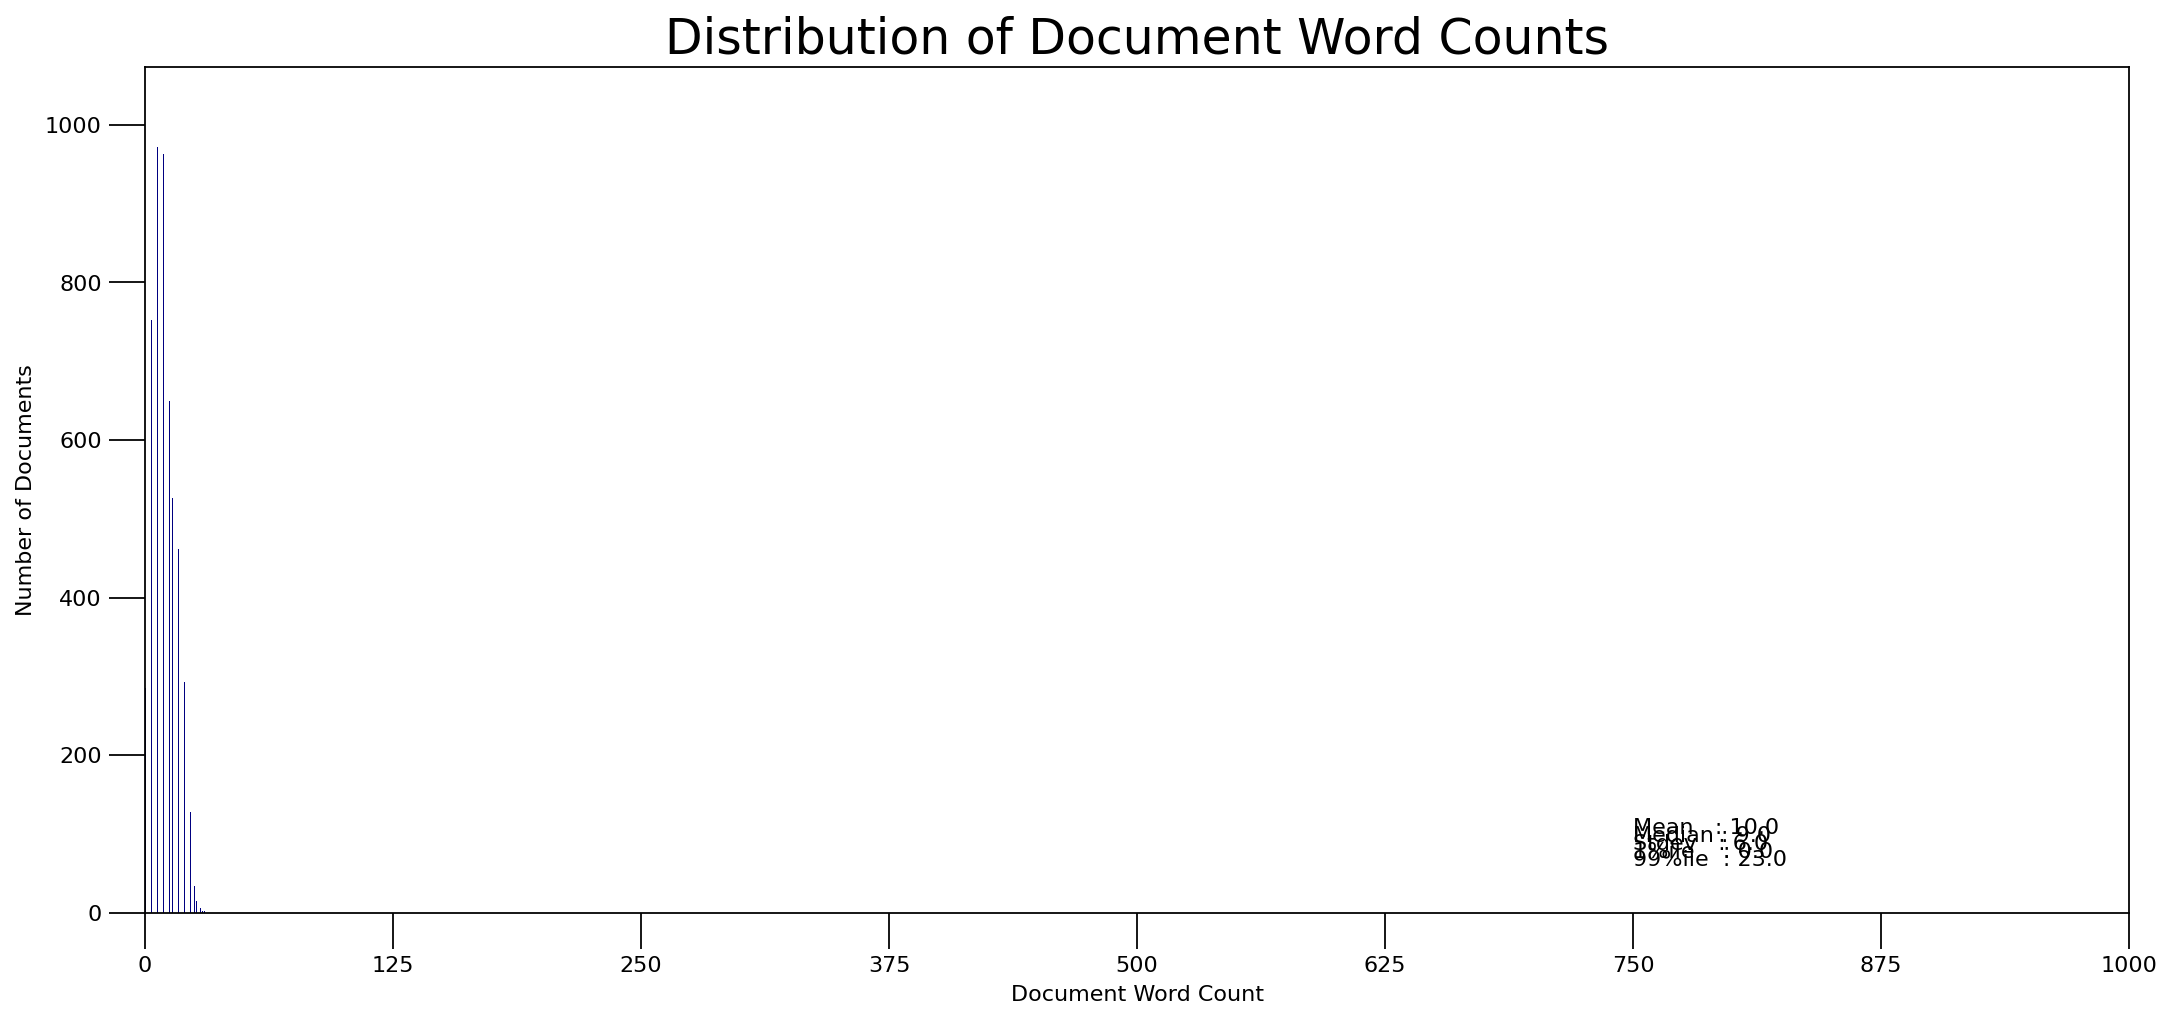

In [64]:
#  Frequency Distribution of Word Counts in Documents
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


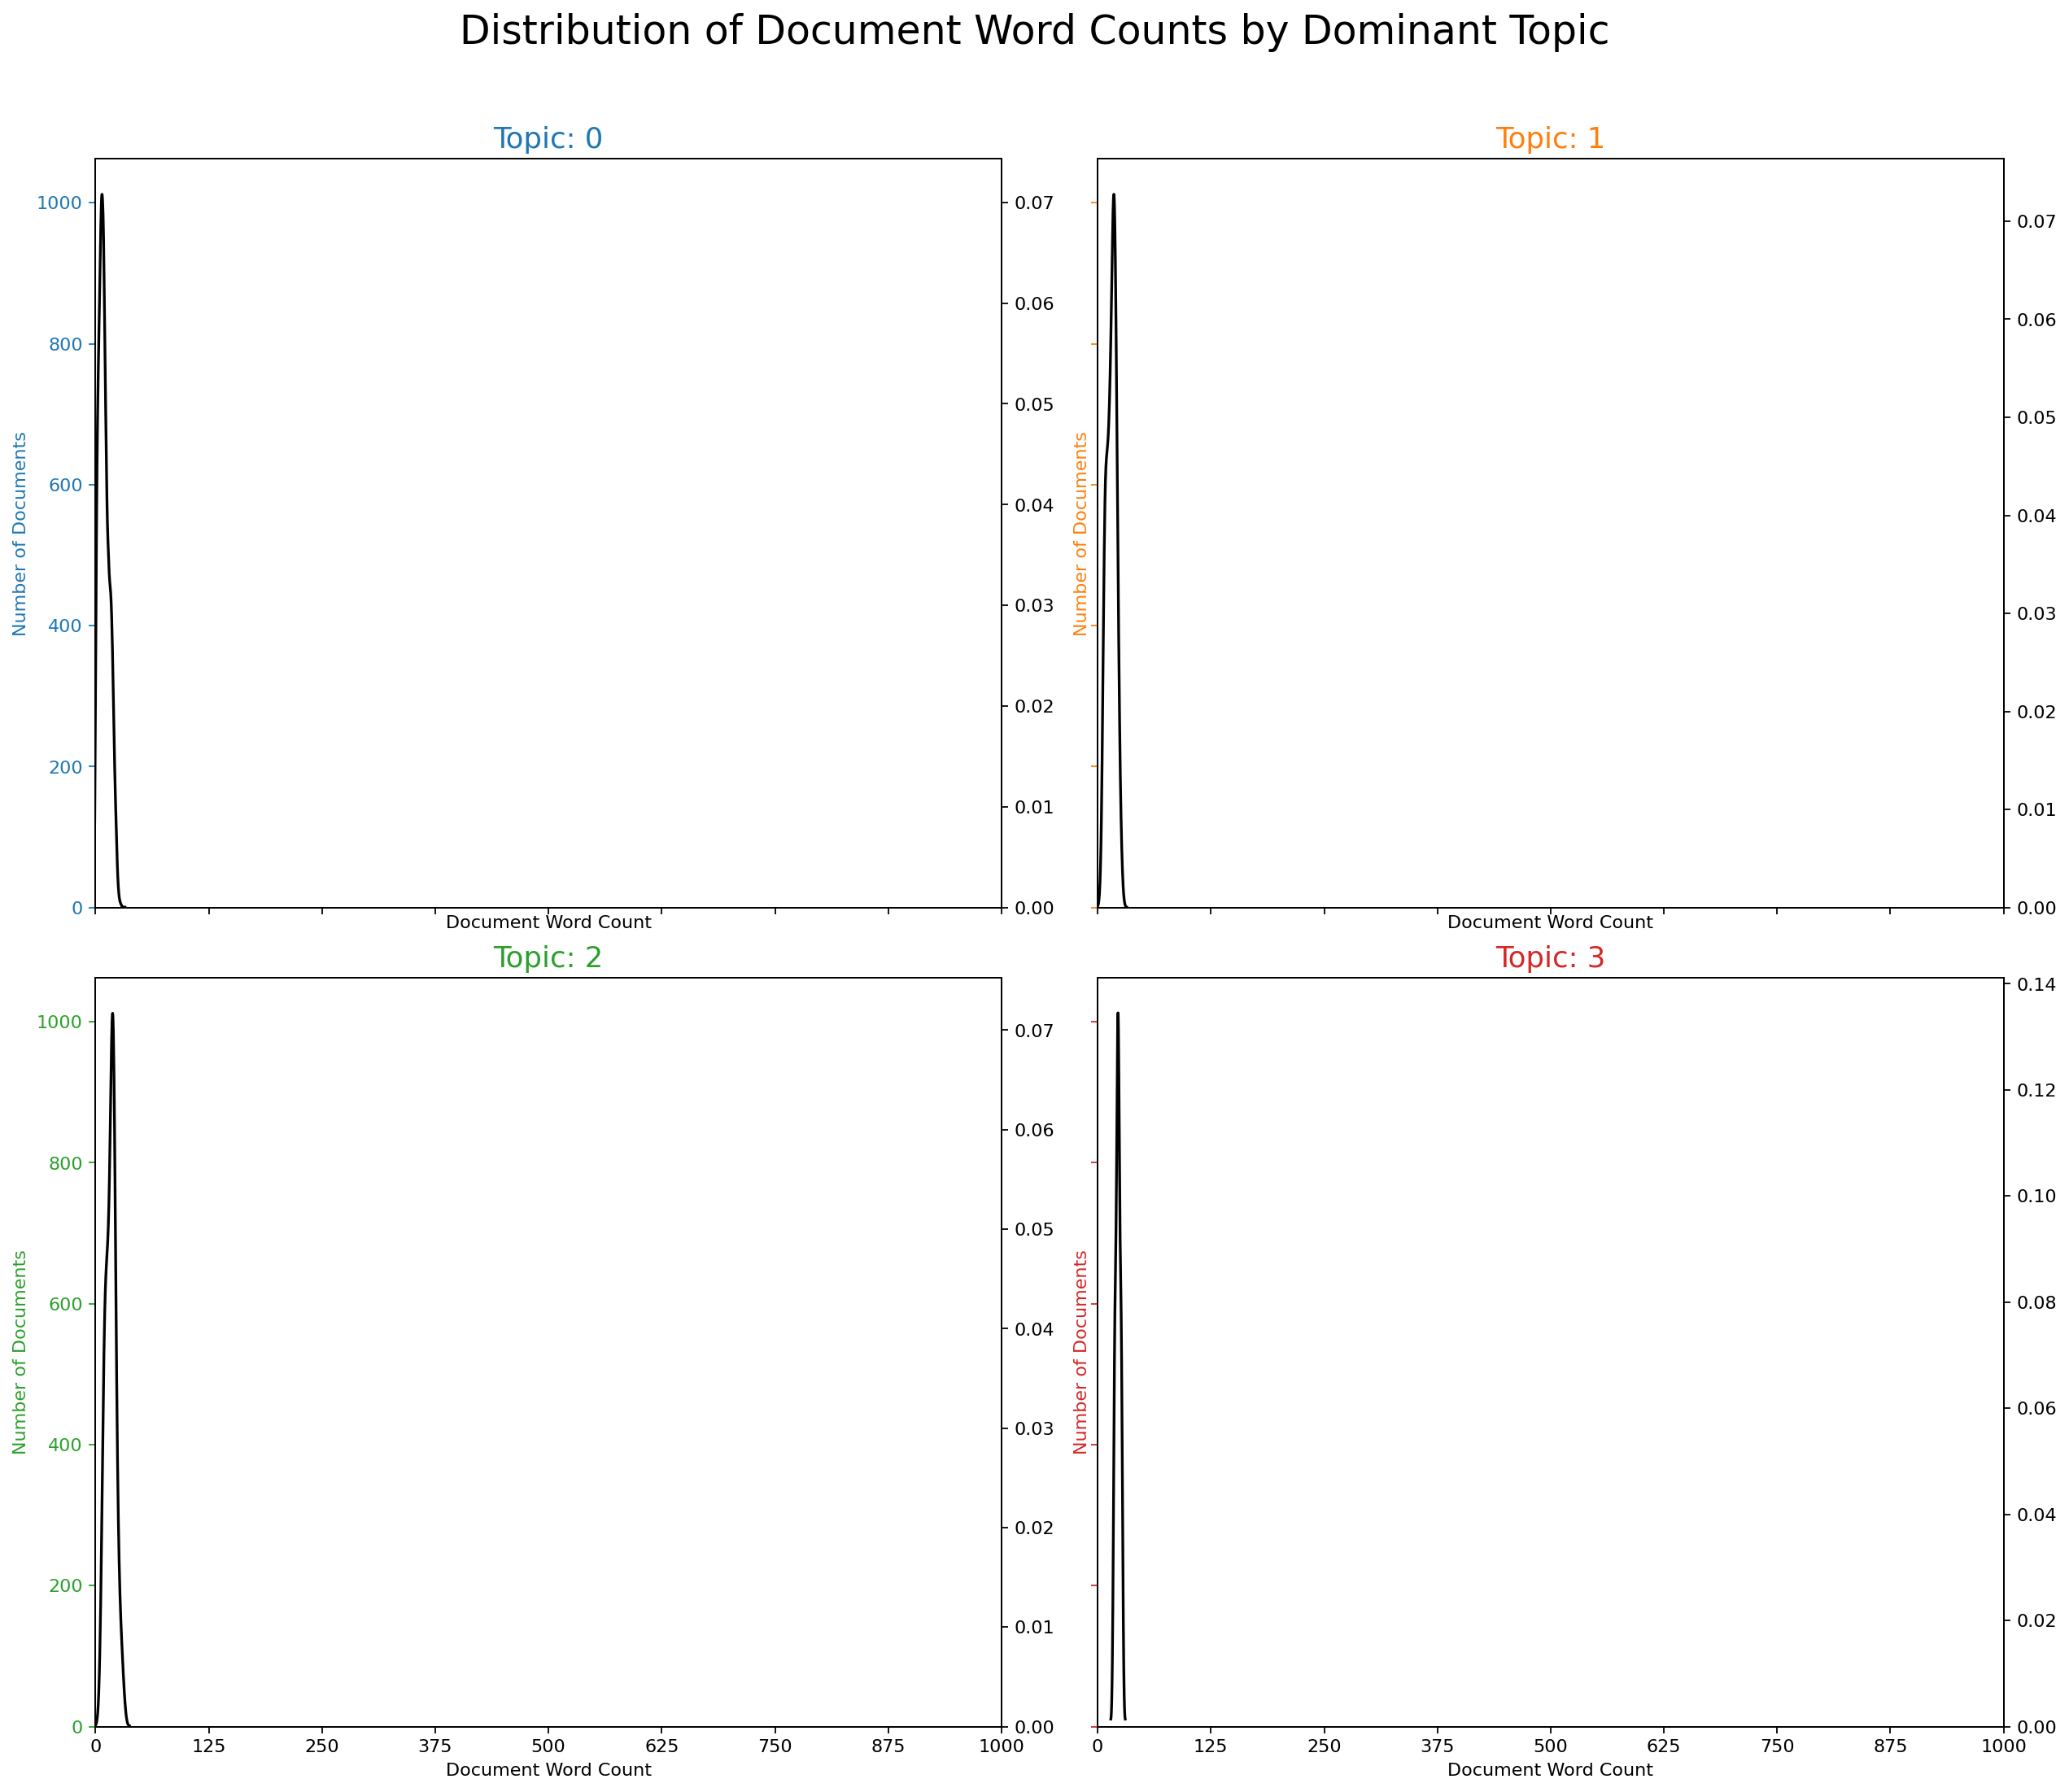

In [65]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

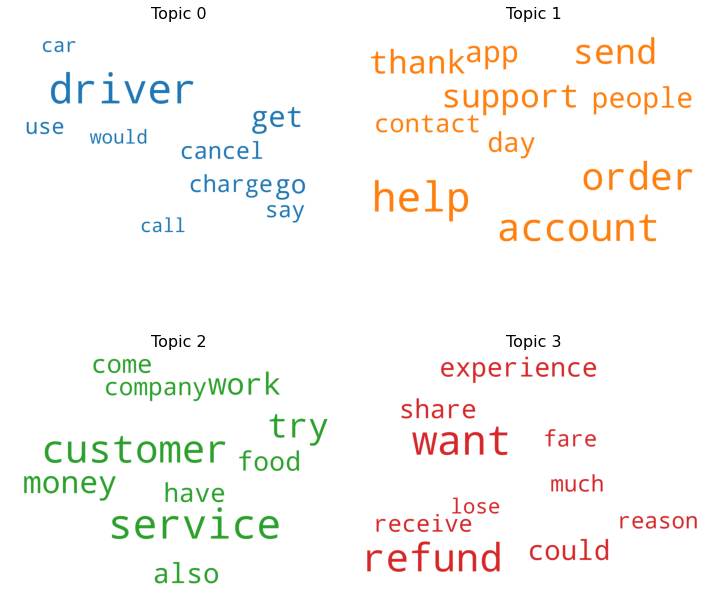

In [66]:
# Word Clouds of Top N Keywords in Each Topic

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

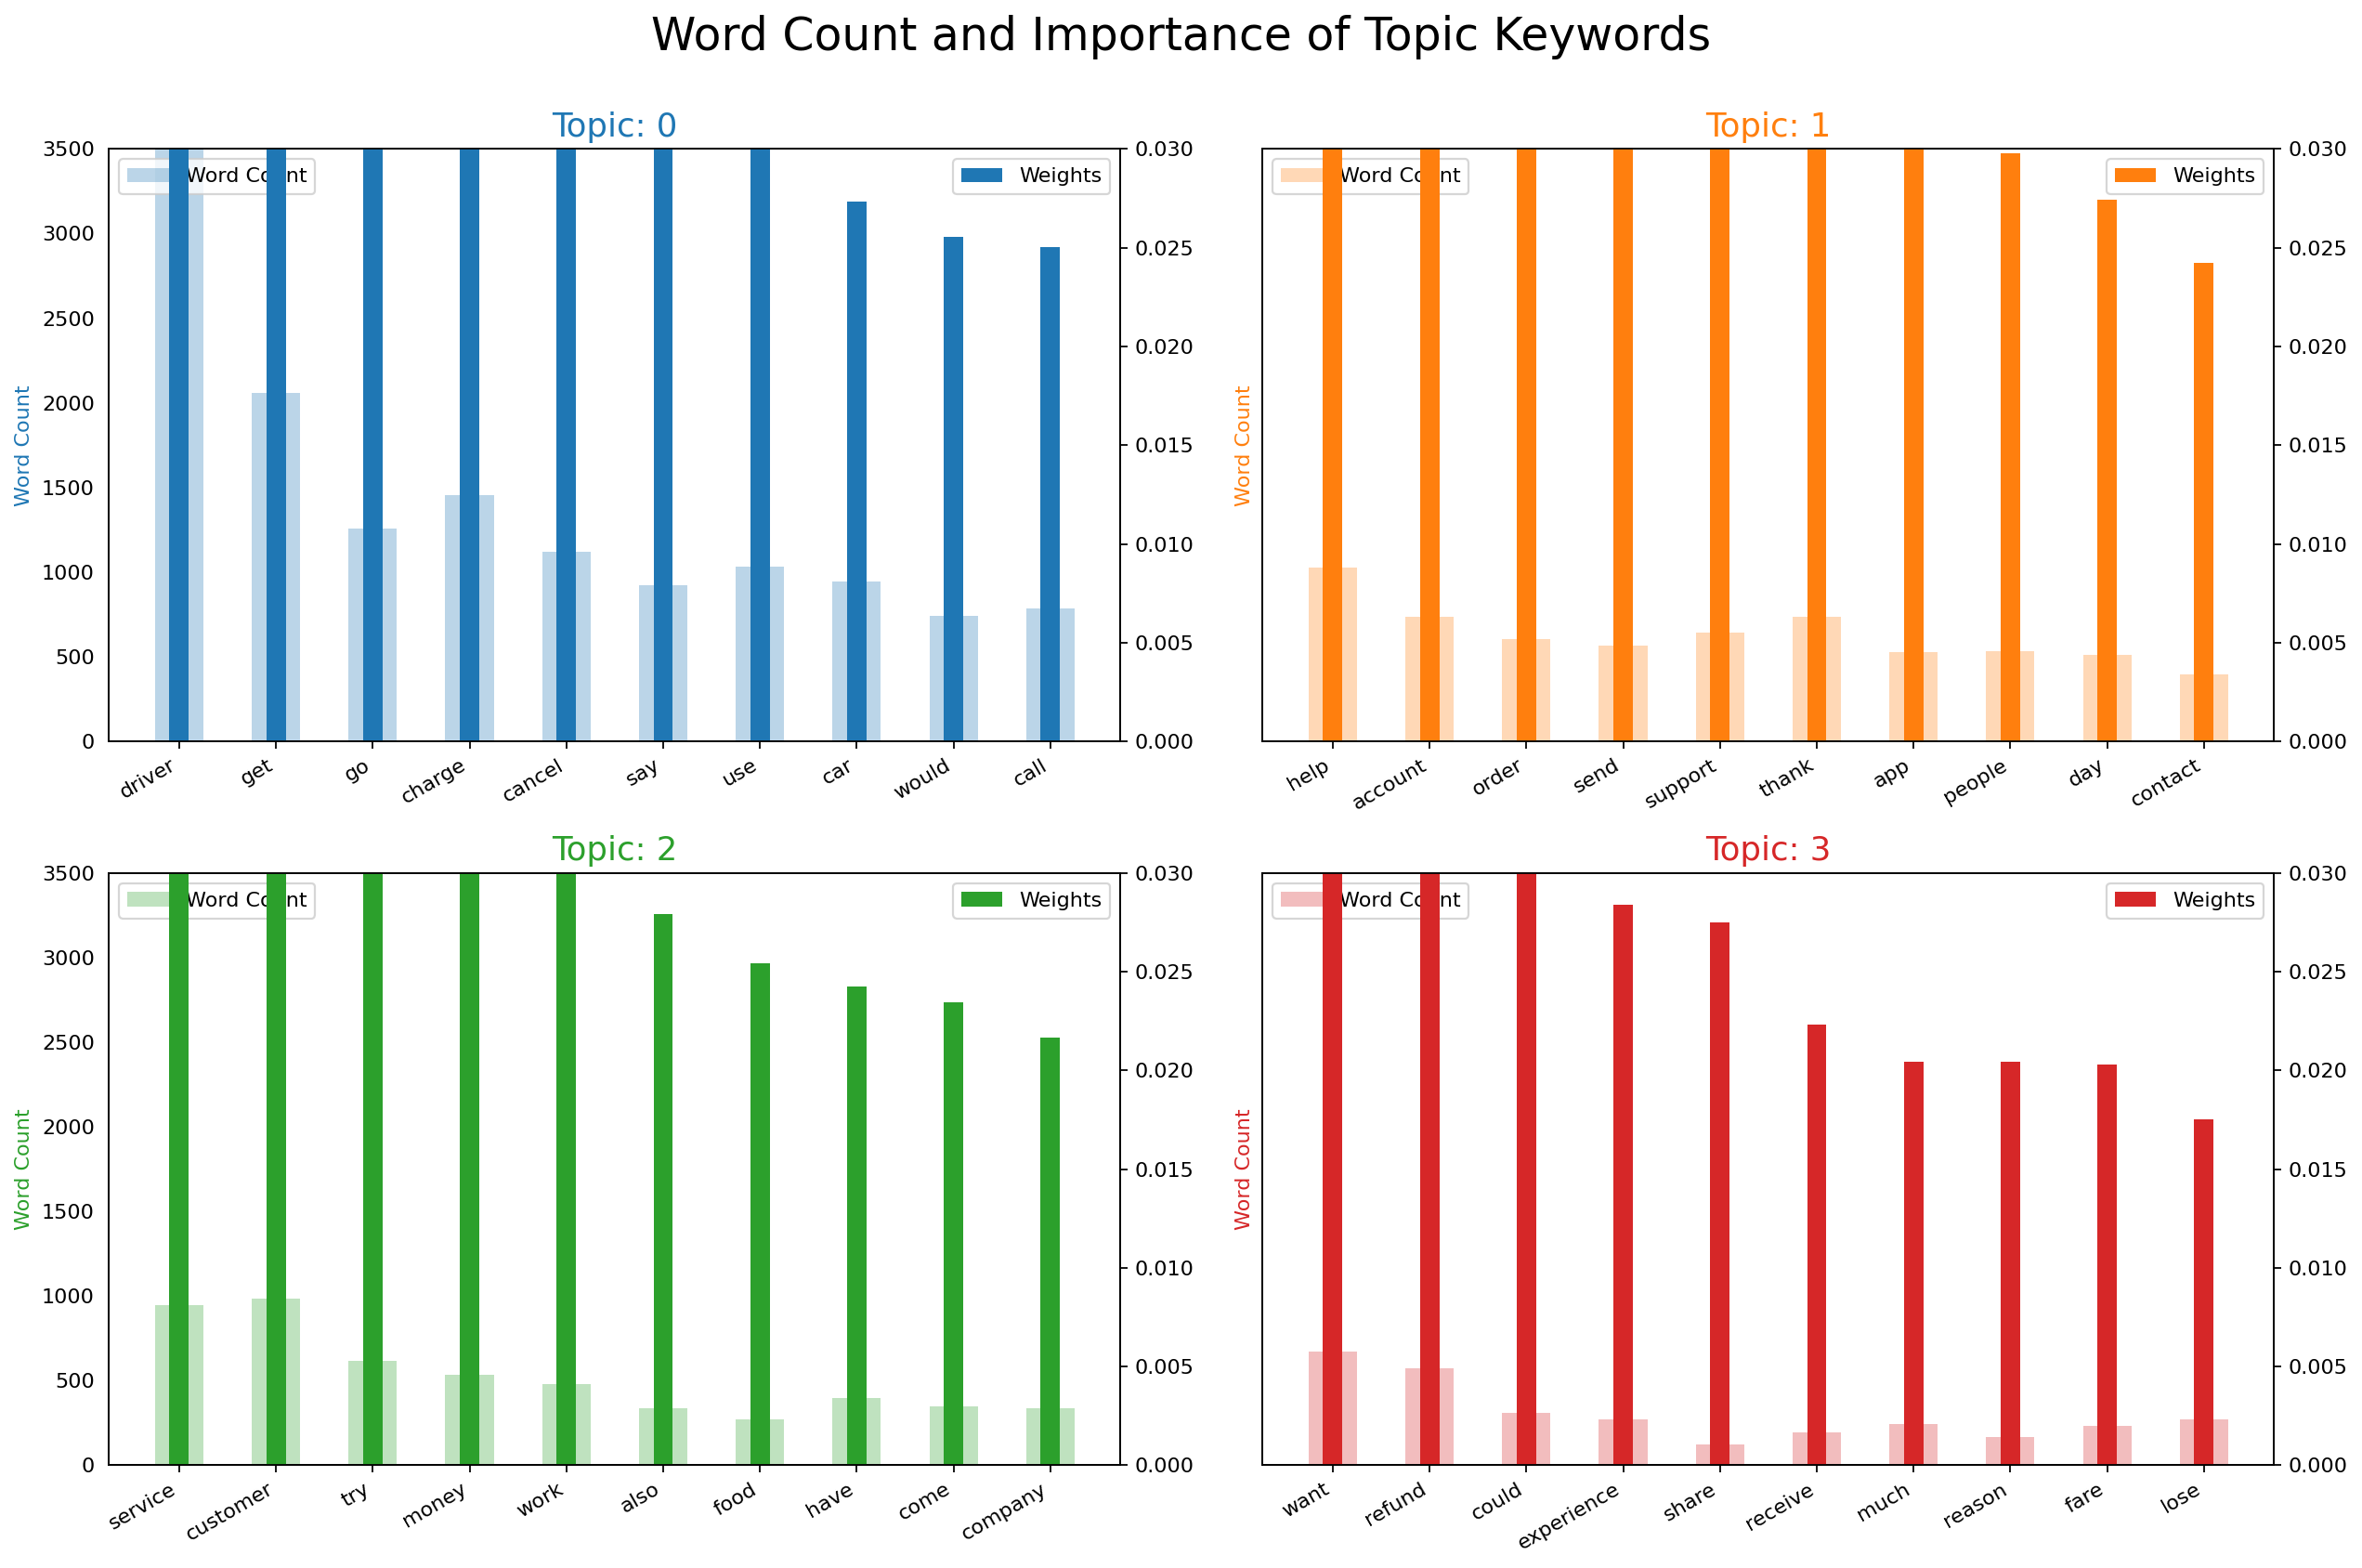

In [67]:
# Word Counts of Topic Keywords

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

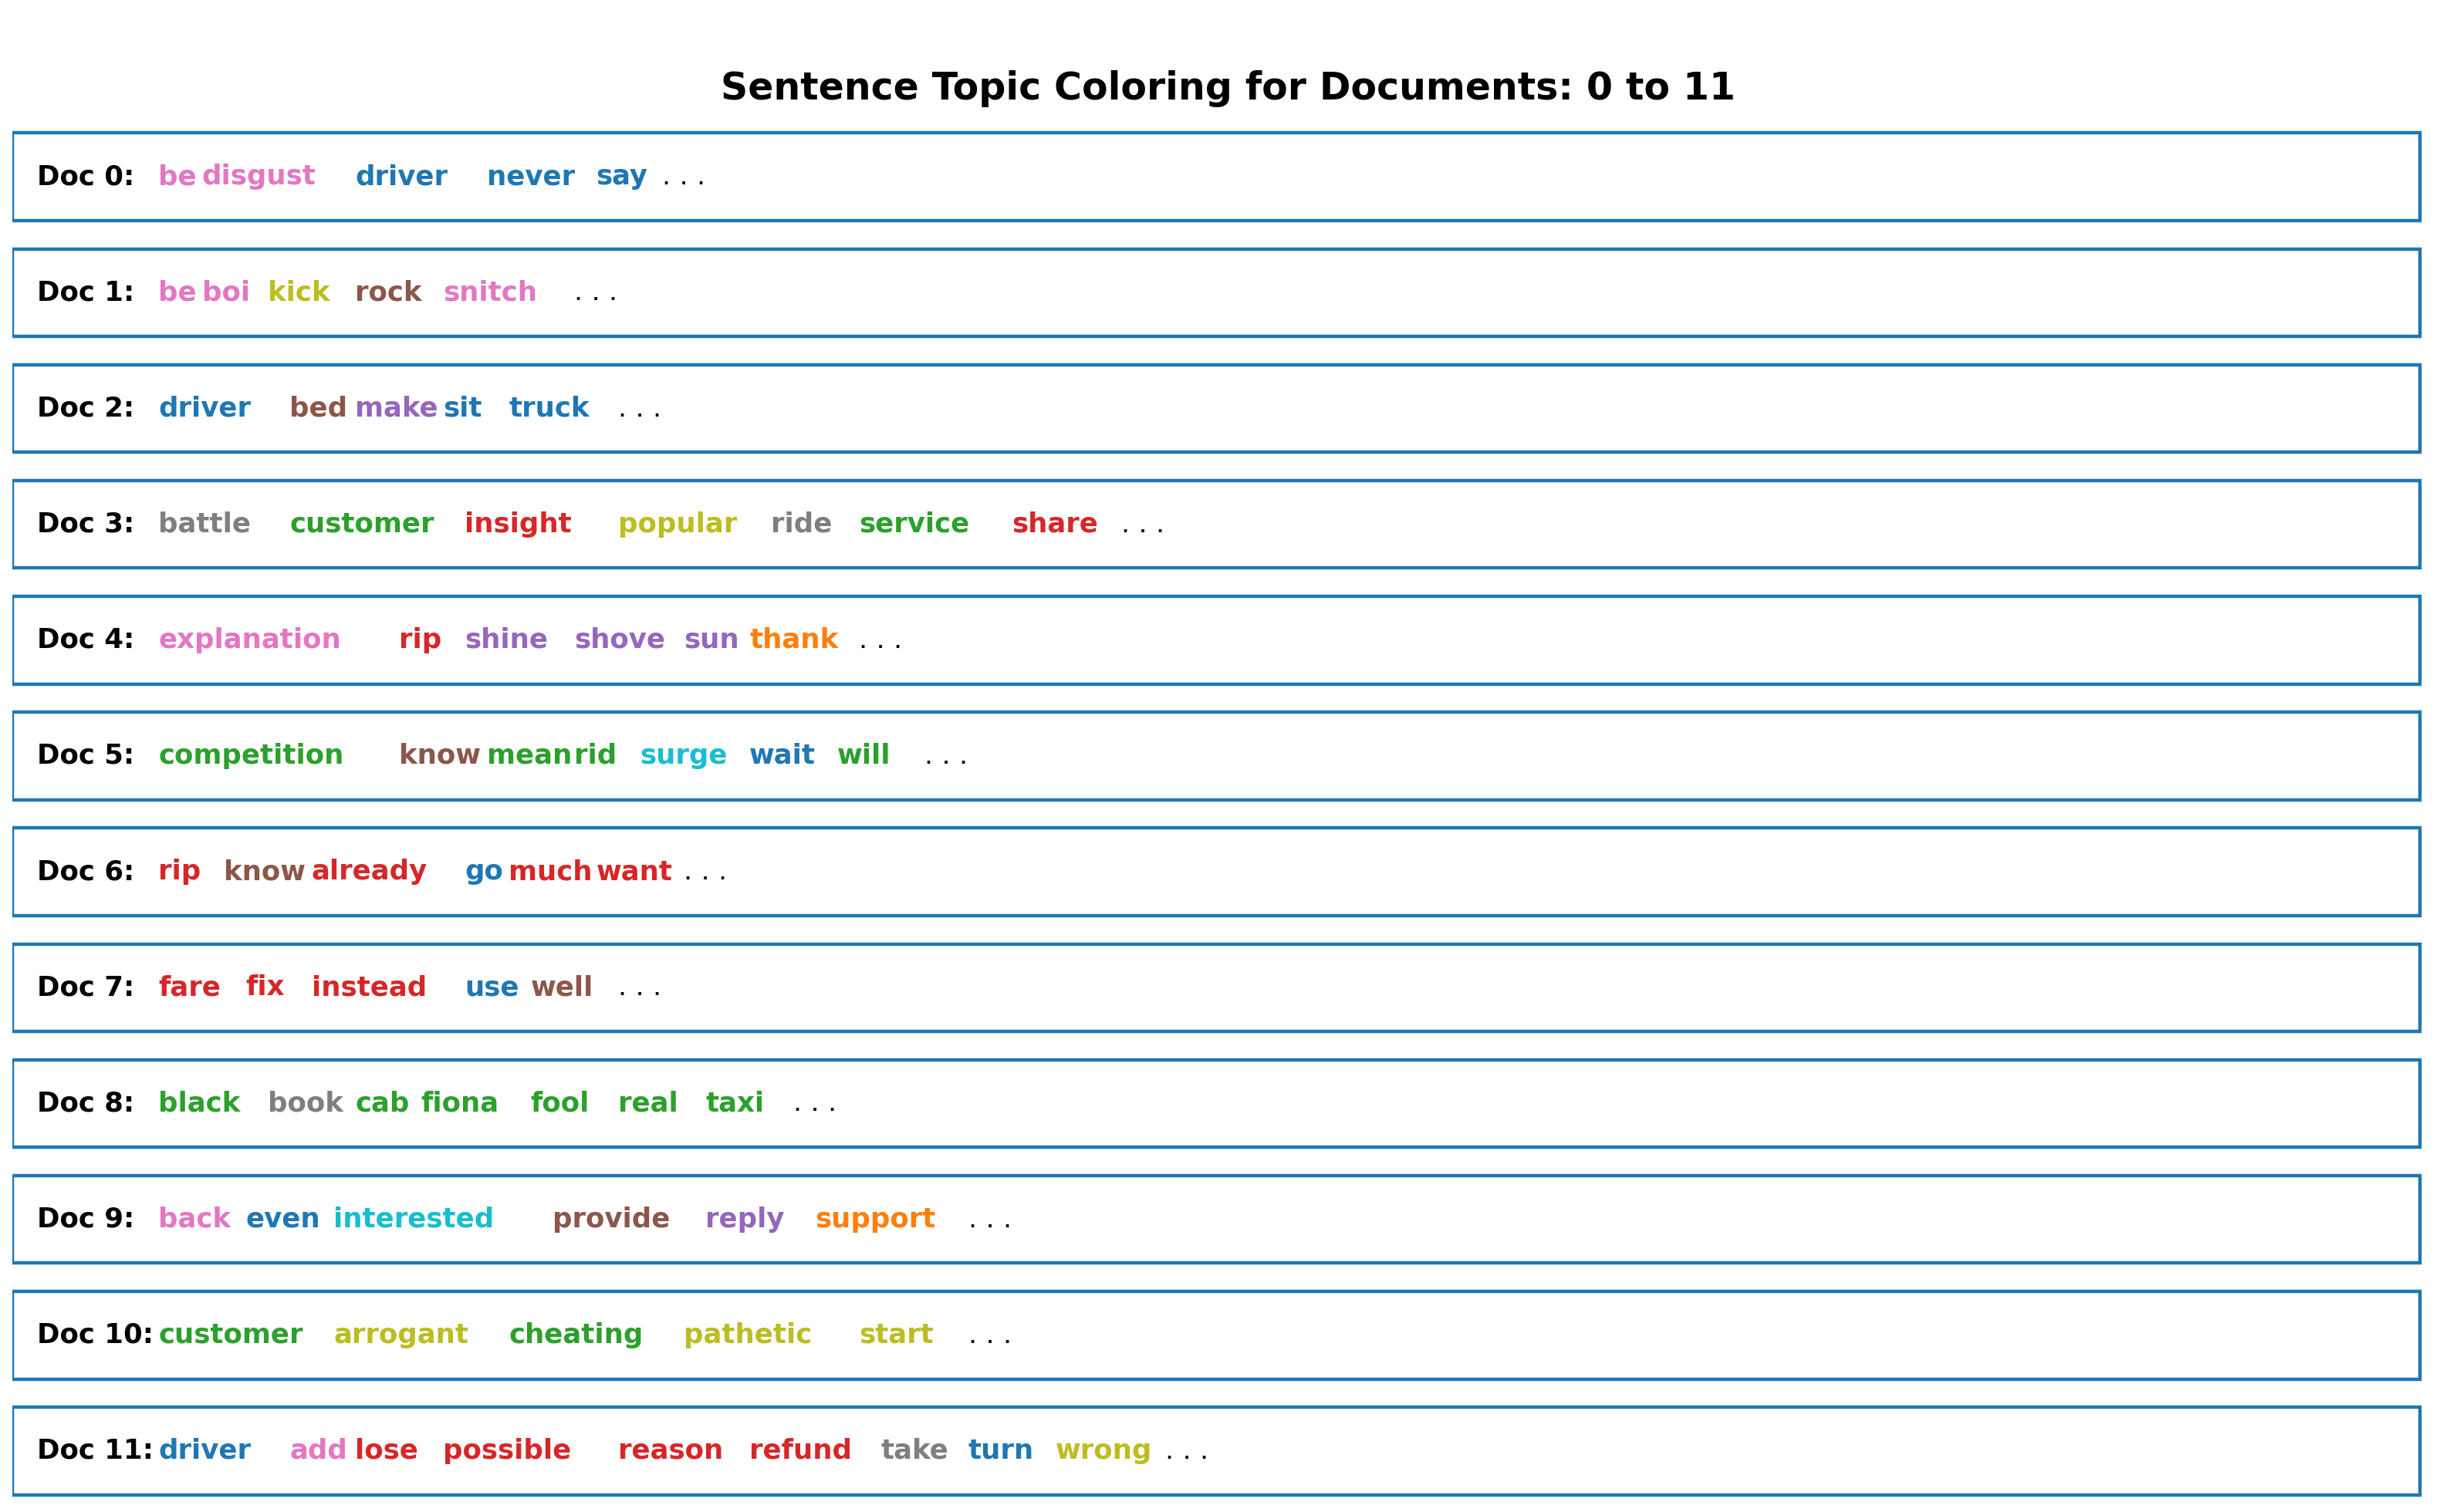

In [68]:
# Sentence Chart Colored by Topic

from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [69]:
# most discussed topics in the documents

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

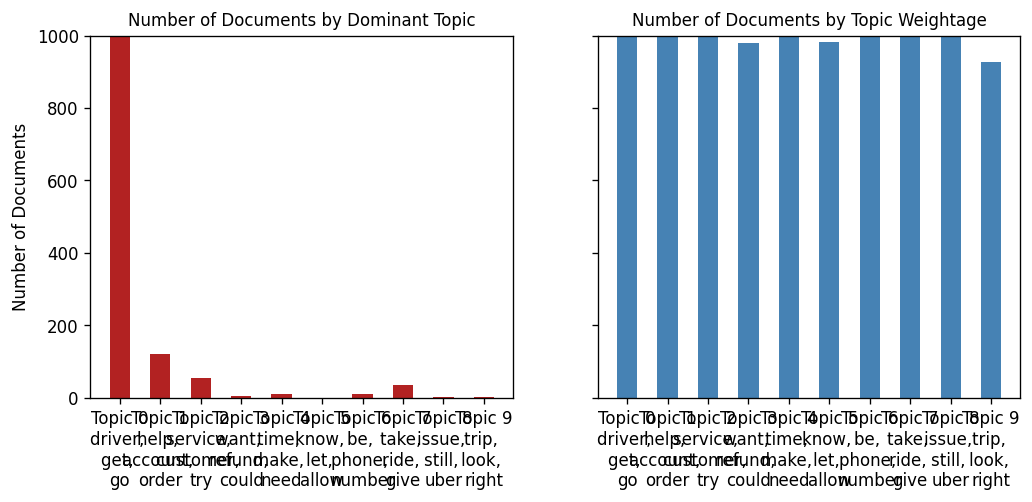

In [70]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [71]:
# t-SNE Clustering Chart

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 2 samples in 0.000s...
[t-SNE] Computed neighbors for 2 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 2 / 2
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 29.818880
[t-SNE] KL divergence after 300 iterations: 0.000000


Refernce:
https://www.machinelearningplus.com